This is a notebook behind this tweet by [@aaronmcdaid](http://twitter.com/aaronmcdaid):

   [A confidence interval can be empty](https://twitter.com/aaronmcdaid/status/1335683999344242692)

In [1]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom, betabinom, uniform
from scipy.stats import zipf as zeta
import seaborn as sns

In [2]:
plt.rcParams["figure.figsize"] = 15.8, 7.9 # 15.8 is the maximum width in Jupyter
plt.style.use('fivethirtyeight') # 538 style

Text(0.5, 0, 'Draws from Binomial(p=a/20, n=20). With one redraw on 13')

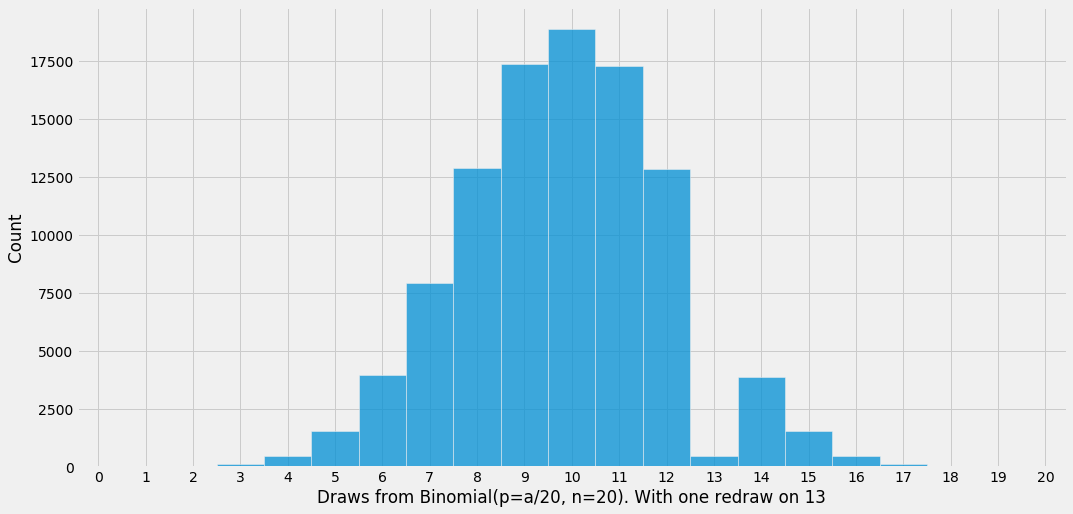

In [3]:
# Function to simulate the mechanism many times

unlucky = 13 # not 13

def gen(n, m):
    rvs = binom(n=20, p=n/20).rvs
    x = rvs(size=m)
    num_thirteens = (x==unlucky).sum()
    replacements = rvs(size=num_thirteens)
    x[x==unlucky] = replacements
    return x
    
x = gen(10, 100000)
sns.histplot(x, discrete=True)
plt.xticks(np.arange(0,20.5));
plt.xlabel('Draws from Binomial(p=a/20, n=20). With one redraw on 13')

Next, I compute the probability mass function (pmf) of this analytically, and then plot it to ensure it's correct and it matches the histogram above:

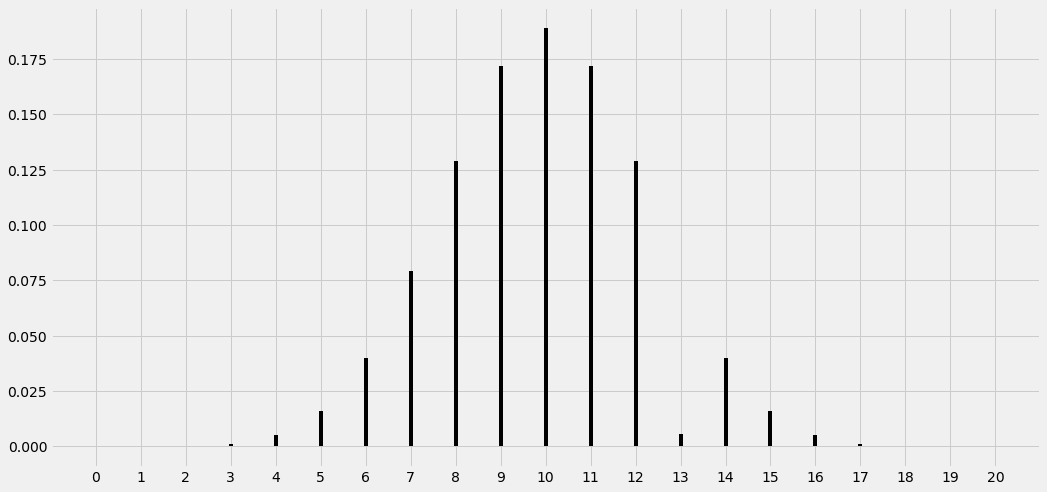

In [4]:
def pmf(n):
    # returns a vector of length 21, giving the probabilities of each of the 21 possible outcomes
    pmf = binom(n=20, p=n/20).pmf
    p13 = pmf(unlucky)
    # each number, other than 13, can occur two different ways: either directly, or after 13 is chosen the first time
    p = pmf(k = np.arange(0,20.5)) * (1+p13)
    p[unlucky] = p13*p13
    assert 0.9999999 < p.sum() <= 1.000000001, p.sum()
    return p

plt.vlines(range(0,21), 0, pmf(10));
plt.xticks(np.arange(0,20.5));

Next, a function to show a table the possibilities. Note how the sum of each row sums to 100%.
A 'interval-generating' function is specified via `f`, which takes two params `n` and `x`. It answers the question, based on the observed data `x`,  _"is `n` in the confidence interval?"_

We demo it with a simple function that says "when we observe `x`, we estimate the parameter as the set {x-1, x, x+1}"

In [5]:
x_range = range(21)
n_range = range(0,21)

def one_cell(n, x, f):
    m = pmf(n)[x]
    in_the_ci = f(n, x)
    text = f'{m:.0%}' if m >= 0.01 else '.'
    if in_the_ci:
        text = '<div style="background-color:lightgreen">**' + text + '**</div>'
    return text

def details_of_one_CI_function(f):
    totals = [(n, sum(pmf(n)[x] for x in x_range if f(n,x))) for n in n_range]
    return display(Markdown(f"""
|| {'|'.join(f"x={i}" for i in x_range)} | |coverage = {min(p for _, p in totals):.1%}|
|{"-|"*(len(x_range)+1)} -|-|
""" + '\n'.join([
f'| **a={n}** | {"|".join([one_cell(n,x,f) for x in x_range])} |  | _{total:.1%}_ |'
        for n, total in totals
])))
details_of_one_CI_function(f=lambda n, x: abs(n-x) < 2)


|| x=0|x=1|x=2|x=3|x=4|x=5|x=6|x=7|x=8|x=9|x=10|x=11|x=12|x=13|x=14|x=15|x=16|x=17|x=18|x=19|x=20 | |coverage = 42.3%|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-| -|-|
| **a=0** | <div style="background-color:lightgreen">**100%**</div>|<div style="background-color:lightgreen">**.**</div>|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _100.0%_ |
| **a=1** | <div style="background-color:lightgreen">**36%**</div>|<div style="background-color:lightgreen">**38%**</div>|<div style="background-color:lightgreen">**19%**</div>|6%|1%|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _92.5%_ |
| **a=2** | 12%|<div style="background-color:lightgreen">**27%**</div>|<div style="background-color:lightgreen">**29%**</div>|<div style="background-color:lightgreen">**19%**</div>|9%|3%|.|.|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _74.5%_ |
| **a=3** | 4%|14%|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**24%**</div>|<div style="background-color:lightgreen">**18%**</div>|10%|5%|2%|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _65.4%_ |
| **a=4** | 1%|6%|14%|<div style="background-color:lightgreen">**21%**</div>|<div style="background-color:lightgreen">**22%**</div>|<div style="background-color:lightgreen">**17%**</div>|11%|5%|2%|.|.|.|.|.|.|.|.|.|.|.|. |  | _59.8%_ |
| **a=5** | .|2%|7%|13%|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**20%**</div>|<div style="background-color:lightgreen">**17%**</div>|11%|6%|3%|.|.|.|.|.|.|.|.|.|.|. |  | _56.1%_ |
| **a=6** | .|.|3%|7%|13%|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**16%**</div>|11%|7%|3%|1%|.|.|.|.|.|.|.|.|. |  | _53.5%_ |
| **a=7** | .|.|1%|3%|7%|13%|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**16%**</div>|12%|7%|3%|1%|.|.|.|.|.|.|.|. |  | _51.9%_ |
| **a=8** | .|.|.|1%|4%|8%|13%|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**16%**</div>|12%|7%|4%|.|.|.|.|.|.|.|. |  | _51.3%_ |
| **a=9** | .|.|.|.|1%|4%|8%|13%|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**17%**</div>|12%|8%|.|2%|.|.|.|.|.|. |  | _51.7%_ |
| **a=10** | .|.|.|.|.|2%|4%|8%|13%|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**17%**</div>|13%|.|4%|2%|.|.|.|.|. |  | _53.3%_ |
| **a=11** | .|.|.|.|.|.|2%|4%|8%|13%|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**20%**</div>|<div style="background-color:lightgreen">**18%**</div>|1%|8%|4%|2%|.|.|.|. |  | _56.0%_ |
| **a=12** | .|.|.|.|.|.|.|2%|4%|8%|14%|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**21%**</div>|<div style="background-color:lightgreen">**3%**</div>|15%|9%|4%|1%|.|.|. |  | _42.3%_ |
| **a=13** | .|.|.|.|.|.|.|.|2%|4%|8%|14%|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**20%**</div>|15%|9%|4%|1%|.|. |  | _42.8%_ |
| **a=14** | .|.|.|.|.|.|.|.|.|1%|4%|8%|13%|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**22%**</div>|<div style="background-color:lightgreen">**21%**</div>|15%|8%|3%|.|. |  | _45.8%_ |
| **a=15** | .|.|.|.|.|.|.|.|.|.|1%|3%|7%|1%|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**21%**</div>|15%|7%|2%|. |  | _62.4%_ |
| **a=16** | .|.|.|.|.|.|.|.|.|.|.|.|2%|.|12%|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**22%**</div>|14%|6%|1% |  | _63.1%_ |
| **a=17** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|5%|10%|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**25%**</div>|<div style="background-color:lightgreen">**23%**</div>|14%|4% |  | _66.5%_ |
| **a=18** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|.|3%|9%|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**29%**</div>|<div style="background-color:lightgreen">**27%**</div>|12% |  | _74.7%_ |
| **a=19** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|1%|6%|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**38%**</div>|<div style="background-color:lightgreen">**36%**</div> |  | _92.5%_ |
| **a=20** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**100%**</div> |  | _100.0%_ |

In [6]:
details_of_one_CI_function(f=lambda n, x: False)


|| x=0|x=1|x=2|x=3|x=4|x=5|x=6|x=7|x=8|x=9|x=10|x=11|x=12|x=13|x=14|x=15|x=16|x=17|x=18|x=19|x=20 | |coverage = 0.0%|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-| -|-|
| **a=0** | 100%|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _0.0%_ |
| **a=1** | 36%|38%|19%|6%|1%|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _0.0%_ |
| **a=2** | 12%|27%|29%|19%|9%|3%|.|.|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _0.0%_ |
| **a=3** | 4%|14%|23%|24%|18%|10%|5%|2%|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _0.0%_ |
| **a=4** | 1%|6%|14%|21%|22%|17%|11%|5%|2%|.|.|.|.|.|.|.|.|.|.|.|. |  | _0.0%_ |
| **a=5** | .|2%|7%|13%|19%|20%|17%|11%|6%|3%|.|.|.|.|.|.|.|.|.|.|. |  | _0.0%_ |
| **a=6** | .|.|3%|7%|13%|18%|19%|16%|11%|7%|3%|1%|.|.|.|.|.|.|.|.|. |  | _0.0%_ |
| **a=7** | .|.|1%|3%|7%|13%|17%|19%|16%|12%|7%|3%|1%|.|.|.|.|.|.|.|. |  | _0.0%_ |
| **a=8** | .|.|.|1%|4%|8%|13%|17%|18%|16%|12%|7%|4%|.|.|.|.|.|.|.|. |  | _0.0%_ |
| **a=9** | .|.|.|.|1%|4%|8%|13%|17%|18%|17%|12%|8%|.|2%|.|.|.|.|.|. |  | _0.0%_ |
| **a=10** | .|.|.|.|.|2%|4%|8%|13%|17%|19%|17%|13%|.|4%|2%|.|.|.|.|. |  | _0.0%_ |
| **a=11** | .|.|.|.|.|.|2%|4%|8%|13%|18%|20%|18%|1%|8%|4%|2%|.|.|.|. |  | _0.0%_ |
| **a=12** | .|.|.|.|.|.|.|2%|4%|8%|14%|19%|21%|3%|15%|9%|4%|1%|.|.|. |  | _0.0%_ |
| **a=13** | .|.|.|.|.|.|.|.|2%|4%|8%|14%|19%|3%|20%|15%|9%|4%|1%|.|. |  | _0.0%_ |
| **a=14** | .|.|.|.|.|.|.|.|.|1%|4%|8%|13%|3%|22%|21%|15%|8%|3%|.|. |  | _0.0%_ |
| **a=15** | .|.|.|.|.|.|.|.|.|.|1%|3%|7%|1%|19%|23%|21%|15%|7%|2%|. |  | _0.0%_ |
| **a=16** | .|.|.|.|.|.|.|.|.|.|.|.|2%|.|12%|18%|23%|22%|14%|6%|1% |  | _0.0%_ |
| **a=17** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|5%|10%|19%|25%|23%|14%|4% |  | _0.0%_ |
| **a=18** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|.|3%|9%|19%|29%|27%|12% |  | _0.0%_ |
| **a=19** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|1%|6%|19%|38%|36% |  | _0.0%_ |
| **a=20** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|100% |  | _0.0%_ |

In [7]:
details_of_one_CI_function(f=lambda g, x: True)


|| x=0|x=1|x=2|x=3|x=4|x=5|x=6|x=7|x=8|x=9|x=10|x=11|x=12|x=13|x=14|x=15|x=16|x=17|x=18|x=19|x=20 | |coverage = 100.0%|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-| -|-|
| **a=0** | <div style="background-color:lightgreen">**100%**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div> |  | _100.0%_ |
| **a=1** | <div style="background-color:lightgreen">**36%**</div>|<div style="background-color:lightgreen">**38%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**6%**</div>|<div style="background-color:lightgreen">**1%**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div> |  | _100.0%_ |
| **a=2** | <div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**27%**</div>|<div style="background-color:lightgreen">**29%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**9%**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div> |  | _100.0%_ |
| **a=3** | <div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**24%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**10%**</div>|<div style="background-color:lightgreen">**5%**</div>|<div style="background-color:lightgreen">**2%**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div> |  | _100.0%_ |
| **a=4** | <div style="background-color:lightgreen">**1%**</div>|<div style="background-color:lightgreen">**6%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**21%**</div>|<div style="background-color:lightgreen">**22%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**11%**</div>|<div style="background-color:lightgreen">**5%**</div>|<div style="background-color:lightgreen">**2%**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div> |  | _100.0%_ |
| **a=5** | <div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**2%**</div>|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**20%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**11%**</div>|<div style="background-color:lightgreen">**6%**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div> |  | _100.0%_ |
| **a=6** | <div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**16%**</div>|<div style="background-color:lightgreen">**11%**</div>|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**1%**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div> |  | _100.0%_ |
| **a=7** | <div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**1%**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**16%**</div>|<div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**1%**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div> |  | _100.0%_ |
| **a=8** | <div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**1%**</div>|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**16%**</div>|<div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div> |  | _100.0%_ |
| **a=9** | <div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**1%**</div>|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**2%**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div> |  | _100.0%_ |
| **a=10** | <div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**2%**</div>|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**2%**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div> |  | _100.0%_ |
| **a=11** | <div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**2%**</div>|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**20%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**1%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**2%**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div> |  | _100.0%_ |
| **a=12** | <div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**2%**</div>|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**21%**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**15%**</div>|<div style="background-color:lightgreen">**9%**</div>|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**1%**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div> |  | _100.0%_ |
| **a=13** | <div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**2%**</div>|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**20%**</div>|<div style="background-color:lightgreen">**15%**</div>|<div style="background-color:lightgreen">**9%**</div>|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**1%**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div> |  | _100.0%_ |
| **a=14** | <div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**1%**</div>|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**22%**</div>|<div style="background-color:lightgreen">**21%**</div>|<div style="background-color:lightgreen">**15%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div> |  | _100.0%_ |
| **a=15** | <div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**1%**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**1%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**21%**</div>|<div style="background-color:lightgreen">**15%**</div>|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**2%**</div>|<div style="background-color:lightgreen">**.**</div> |  | _100.0%_ |
| **a=16** | <div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**2%**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**22%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**6%**</div>|<div style="background-color:lightgreen">**1%**</div> |  | _100.0%_ |
| **a=17** | <div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**5%**</div>|<div style="background-color:lightgreen">**10%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**25%**</div>|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**4%**</div> |  | _100.0%_ |
| **a=18** | <div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**9%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**29%**</div>|<div style="background-color:lightgreen">**27%**</div>|<div style="background-color:lightgreen">**12%**</div> |  | _100.0%_ |
| **a=19** | <div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**1%**</div>|<div style="background-color:lightgreen">**6%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**38%**</div>|<div style="background-color:lightgreen">**36%**</div> |  | _100.0%_ |
| **a=20** | <div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**.**</div>|<div style="background-color:lightgreen">**100%**</div> |  | _100.0%_ |

In [8]:
def _a_credible_interval(x, coverage):
    # A uniform prior
    if coverage == 0:
        return set()
    pmfs = [ (pmf(n)[x], n) for n in n_range ]
    mode_to_lowest = sorted(pmfs, reverse=True)
    del pmfs
    ms = [m for m, _ in mode_to_lowest]
    ms = np.array(ms) / sum(ms)
    size = 1 + (np.cumsum(ms) < coverage).sum()
    smallest_set = mode_to_lowest[:size]
    return set(x for _, x in smallest_set)

def credible_interval(coverage):
    map_of_smallest = { x: _a_credible_interval(x, coverage) for x in range(21) }
    def go(n, x):
        return n in map_of_smallest[x]
    return go

details_of_one_CI_function(f=credible_interval(0.90))


|| x=0|x=1|x=2|x=3|x=4|x=5|x=6|x=7|x=8|x=9|x=10|x=11|x=12|x=13|x=14|x=15|x=16|x=17|x=18|x=19|x=20 | |coverage = 87.1%|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-| -|-|
| **a=0** | <div style="background-color:lightgreen">**100%**</div>|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _100.0%_ |
| **a=1** | <div style="background-color:lightgreen">**36%**</div>|<div style="background-color:lightgreen">**38%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**6%**</div>|1%|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _98.4%_ |
| **a=2** | <div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**27%**</div>|<div style="background-color:lightgreen">**29%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**9%**</div>|3%|.|.|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _95.7%_ |
| **a=3** | 4%|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**24%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**10%**</div>|<div style="background-color:lightgreen">**5%**</div>|2%|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _93.9%_ |
| **a=4** | 1%|<div style="background-color:lightgreen">**6%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**21%**</div>|<div style="background-color:lightgreen">**22%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**11%**</div>|<div style="background-color:lightgreen">**5%**</div>|2%|.|.|.|.|.|.|.|.|.|.|.|. |  | _95.6%_ |
| **a=5** | .|2%|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**20%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**11%**</div>|<div style="background-color:lightgreen">**6%**</div>|3%|.|.|.|.|.|.|.|.|.|.|. |  | _93.5%_ |
| **a=6** | .|.|3%|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**16%**</div>|<div style="background-color:lightgreen">**11%**</div>|<div style="background-color:lightgreen">**7%**</div>|3%|1%|.|.|.|.|.|.|.|.|. |  | _91.7%_ |
| **a=7** | .|.|1%|3%|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**16%**</div>|<div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**7%**</div>|3%|1%|.|.|.|.|.|.|.|. |  | _90.7%_ |
| **a=8** | .|.|.|1%|4%|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**16%**</div>|<div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**7%**</div>|4%|.|.|.|.|.|.|.|. |  | _90.6%_ |
| **a=9** | .|.|.|.|1%|4%|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**8%**</div>|.|2%|.|.|.|.|.|. |  | _91.9%_ |
| **a=10** | .|.|.|.|.|2%|4%|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**13%**</div>|.|4%|2%|.|.|.|.|. |  | _87.1%_ |
| **a=11** | .|.|.|.|.|.|2%|4%|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**20%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**1%**</div>|<div style="background-color:lightgreen">**8%**</div>|4%|2%|.|.|.|. |  | _87.3%_ |
| **a=12** | .|.|.|.|.|.|.|2%|4%|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**21%**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**15%**</div>|<div style="background-color:lightgreen">**9%**</div>|4%|1%|.|.|. |  | _87.5%_ |
| **a=13** | .|.|.|.|.|.|.|.|2%|4%|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**20%**</div>|<div style="background-color:lightgreen">**15%**</div>|<div style="background-color:lightgreen">**9%**</div>|4%|1%|.|. |  | _88.4%_ |
| **a=14** | .|.|.|.|.|.|.|.|.|1%|4%|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**22%**</div>|<div style="background-color:lightgreen">**21%**</div>|<div style="background-color:lightgreen">**15%**</div>|<div style="background-color:lightgreen">**8%**</div>|3%|.|. |  | _90.3%_ |
| **a=15** | .|.|.|.|.|.|.|.|.|.|1%|3%|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**1%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**21%**</div>|<div style="background-color:lightgreen">**15%**</div>|<div style="background-color:lightgreen">**7%**</div>|2%|. |  | _92.7%_ |
| **a=16** | .|.|.|.|.|.|.|.|.|.|.|.|2%|.|<div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**22%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**6%**</div>|1% |  | _95.1%_ |
| **a=17** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|<div style="background-color:lightgreen">**5%**</div>|<div style="background-color:lightgreen">**10%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**25%**</div>|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**14%**</div>|4% |  | _95.4%_ |
| **a=18** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|.|3%|<div style="background-color:lightgreen">**9%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**29%**</div>|<div style="background-color:lightgreen">**27%**</div>|<div style="background-color:lightgreen">**12%**</div> |  | _95.9%_ |
| **a=19** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|1%|<div style="background-color:lightgreen">**6%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**38%**</div>|<div style="background-color:lightgreen">**36%**</div> |  | _98.4%_ |
| **a=20** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|<div style="background-color:lightgreen">**100%**</div> |  | _100.0%_ |

In [9]:
def given_g_and_coverage__the_smallest_set(n, coverage):
    if coverage == 0:
        return set()
    pmfs = [ (pmf(n)[x], x) for x in x_range ]
    mode_to_lowest = sorted(pmfs, reverse=True)
    del pmfs
    size = 1 + (np.cumsum([m for m, _ in mode_to_lowest]) < coverage).sum()
    smallest_set = mode_to_lowest[:size]
    sum_ps = sum(m for m, _ in smallest_set)
    assert (coverage-1e-5) <= sum_ps <= 1.0, sum_ps
    return set(x for _, x in smallest_set)

given_g_and_coverage__the_smallest_set(10, .95)

{6, 7, 8, 9, 10, 11, 12, 14}

Text(0.5, 0, 'Draws from Binomial(p=a/20, n=20). With one redraw on 13')

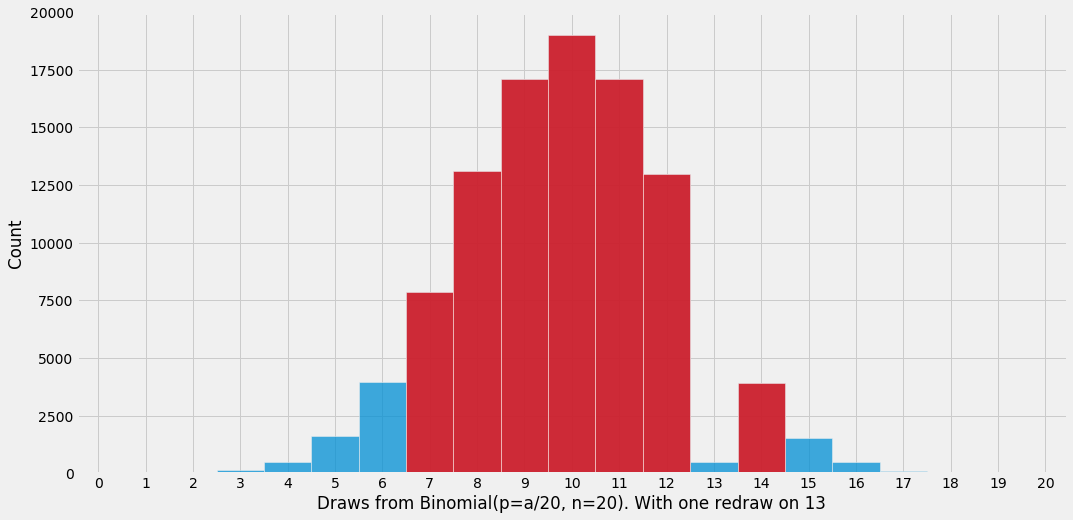

In [10]:
# Function to simulate the mechanism many times

unlucky = 13 # not 13

def gen(n, m):
    rvs = binom(n=20, p=n/20).rvs
    x = rvs(size=m)
    num_thirteens = (x==unlucky).sum()
    replacements = rvs(size=num_thirteens)
    x[x==unlucky] = replacements
    return x
    
red = given_g_and_coverage__the_smallest_set(10, .90)
x = gen(10, 100000)
sns.histplot(x, discrete=True)
sns.histplot([_ for _ in x if _ in red], discrete=True, color='red')
plt.xticks(np.arange(0,20.5));
plt.xlabel('Draws from Binomial(p=a/20, n=20). With one redraw on 13')

In [11]:
def best_ci(coverage):
    map_of_smallest = { n: given_g_and_coverage__the_smallest_set(n, coverage) for n in n_range }
    def go(n, x):
        return x in map_of_smallest[n]
        return abs(n-x) < 3
    return go

In [12]:
details_of_one_CI_function(f=best_ci(0.95))


|| x=0|x=1|x=2|x=3|x=4|x=5|x=6|x=7|x=8|x=9|x=10|x=11|x=12|x=13|x=14|x=15|x=16|x=17|x=18|x=19|x=20 | |coverage = 95.0%|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-| -|-|
| **a=0** | <div style="background-color:lightgreen">**100%**</div>|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _100.0%_ |
| **a=1** | <div style="background-color:lightgreen">**36%**</div>|<div style="background-color:lightgreen">**38%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**6%**</div>|1%|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _98.4%_ |
| **a=2** | <div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**27%**</div>|<div style="background-color:lightgreen">**29%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**9%**</div>|3%|.|.|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _95.7%_ |
| **a=3** | <div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**24%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**10%**</div>|<div style="background-color:lightgreen">**5%**</div>|2%|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _97.8%_ |
| **a=4** | 1%|<div style="background-color:lightgreen">**6%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**21%**</div>|<div style="background-color:lightgreen">**22%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**11%**</div>|<div style="background-color:lightgreen">**5%**</div>|2%|.|.|.|.|.|.|.|.|.|.|.|. |  | _95.6%_ |
| **a=5** | .|2%|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**20%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**11%**</div>|<div style="background-color:lightgreen">**6%**</div>|<div style="background-color:lightgreen">**3%**</div>|.|.|.|.|.|.|.|.|.|.|. |  | _96.2%_ |
| **a=6** | .|.|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**16%**</div>|<div style="background-color:lightgreen">**11%**</div>|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**3%**</div>|1%|.|.|.|.|.|.|.|.|. |  | _97.6%_ |
| **a=7** | .|.|1%|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**16%**</div>|<div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**3%**</div>|1%|.|.|.|.|.|.|.|. |  | _97.3%_ |
| **a=8** | .|.|.|1%|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**16%**</div>|<div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**4%**</div>|.|.|.|.|.|.|.|. |  | _97.7%_ |
| **a=9** | .|.|.|.|1%|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**8%**</div>|.|2%|.|.|.|.|.|. |  | _95.7%_ |
| **a=10** | .|.|.|.|.|2%|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**13%**</div>|.|<div style="background-color:lightgreen">**4%**</div>|2%|.|.|.|.|. |  | _95.0%_ |
| **a=11** | .|.|.|.|.|.|<div style="background-color:lightgreen">**2%**</div>|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**20%**</div>|<div style="background-color:lightgreen">**18%**</div>|1%|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**4%**</div>|2%|.|.|.|. |  | _95.7%_ |
| **a=12** | .|.|.|.|.|.|.|2%|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**21%**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**15%**</div>|<div style="background-color:lightgreen">**9%**</div>|<div style="background-color:lightgreen">**4%**</div>|1%|.|.|. |  | _95.7%_ |
| **a=13** | .|.|.|.|.|.|.|.|2%|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**20%**</div>|<div style="background-color:lightgreen">**15%**</div>|<div style="background-color:lightgreen">**9%**</div>|<div style="background-color:lightgreen">**4%**</div>|1%|.|. |  | _96.2%_ |
| **a=14** | .|.|.|.|.|.|.|.|.|1%|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**22%**</div>|<div style="background-color:lightgreen">**21%**</div>|<div style="background-color:lightgreen">**15%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**3%**</div>|.|. |  | _97.1%_ |
| **a=15** | .|.|.|.|.|.|.|.|.|.|1%|<div style="background-color:lightgreen">**3%**</div>|<div style="background-color:lightgreen">**7%**</div>|1%|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**21%**</div>|<div style="background-color:lightgreen">**15%**</div>|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**2%**</div>|. |  | _96.8%_ |
| **a=16** | .|.|.|.|.|.|.|.|.|.|.|.|2%|.|<div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**22%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**6%**</div>|1% |  | _95.1%_ |
| **a=17** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|<div style="background-color:lightgreen">**5%**</div>|<div style="background-color:lightgreen">**10%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**25%**</div>|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**14%**</div>|4% |  | _95.4%_ |
| **a=18** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|.|3%|<div style="background-color:lightgreen">**9%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**29%**</div>|<div style="background-color:lightgreen">**27%**</div>|<div style="background-color:lightgreen">**12%**</div> |  | _95.9%_ |
| **a=19** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|1%|<div style="background-color:lightgreen">**6%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**38%**</div>|<div style="background-color:lightgreen">**36%**</div> |  | _98.4%_ |
| **a=20** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|<div style="background-color:lightgreen">**100%**</div> |  | _100.0%_ |

In [13]:
details_of_one_CI_function(f=best_ci(0.90))


|| x=0|x=1|x=2|x=3|x=4|x=5|x=6|x=7|x=8|x=9|x=10|x=11|x=12|x=13|x=14|x=15|x=16|x=17|x=18|x=19|x=20 | |coverage = 90.2%|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-| -|-|
| **a=0** | <div style="background-color:lightgreen">**100%**</div>|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _100.0%_ |
| **a=1** | <div style="background-color:lightgreen">**36%**</div>|<div style="background-color:lightgreen">**38%**</div>|<div style="background-color:lightgreen">**19%**</div>|6%|1%|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _92.5%_ |
| **a=2** | <div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**27%**</div>|<div style="background-color:lightgreen">**29%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**9%**</div>|3%|.|.|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _95.7%_ |
| **a=3** | 4%|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**24%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**10%**</div>|<div style="background-color:lightgreen">**5%**</div>|2%|.|.|.|.|.|.|.|.|.|.|.|.|. |  | _93.9%_ |
| **a=4** | 1%|<div style="background-color:lightgreen">**6%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**21%**</div>|<div style="background-color:lightgreen">**22%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**11%**</div>|5%|2%|.|.|.|.|.|.|.|.|.|.|.|. |  | _90.2%_ |
| **a=5** | .|2%|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**20%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**11%**</div>|<div style="background-color:lightgreen">**6%**</div>|3%|.|.|.|.|.|.|.|.|.|.|. |  | _93.5%_ |
| **a=6** | .|.|3%|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**16%**</div>|<div style="background-color:lightgreen">**11%**</div>|<div style="background-color:lightgreen">**7%**</div>|3%|1%|.|.|.|.|.|.|.|.|. |  | _91.7%_ |
| **a=7** | .|.|1%|3%|<div style="background-color:lightgreen">**7%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**16%**</div>|<div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**7%**</div>|3%|1%|.|.|.|.|.|.|.|. |  | _90.7%_ |
| **a=8** | .|.|.|1%|4%|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**16%**</div>|<div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**7%**</div>|4%|.|.|.|.|.|.|.|. |  | _90.6%_ |
| **a=9** | .|.|.|.|1%|4%|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**8%**</div>|.|2%|.|.|.|.|.|. |  | _91.9%_ |
| **a=10** | .|.|.|.|.|2%|4%|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**17%**</div>|<div style="background-color:lightgreen">**13%**</div>|.|<div style="background-color:lightgreen">**4%**</div>|2%|.|.|.|.|. |  | _91.0%_ |
| **a=11** | .|.|.|.|.|.|2%|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**20%**</div>|<div style="background-color:lightgreen">**18%**</div>|1%|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**4%**</div>|2%|.|.|.|. |  | _94.0%_ |
| **a=12** | .|.|.|.|.|.|.|2%|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**21%**</div>|3%|<div style="background-color:lightgreen">**15%**</div>|<div style="background-color:lightgreen">**9%**</div>|<div style="background-color:lightgreen">**4%**</div>|1%|.|.|. |  | _92.9%_ |
| **a=13** | .|.|.|.|.|.|.|.|2%|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**19%**</div>|3%|<div style="background-color:lightgreen">**20%**</div>|<div style="background-color:lightgreen">**15%**</div>|<div style="background-color:lightgreen">**9%**</div>|<div style="background-color:lightgreen">**4%**</div>|1%|.|. |  | _92.8%_ |
| **a=14** | .|.|.|.|.|.|.|.|.|1%|<div style="background-color:lightgreen">**4%**</div>|<div style="background-color:lightgreen">**8%**</div>|<div style="background-color:lightgreen">**13%**</div>|3%|<div style="background-color:lightgreen">**22%**</div>|<div style="background-color:lightgreen">**21%**</div>|<div style="background-color:lightgreen">**15%**</div>|<div style="background-color:lightgreen">**8%**</div>|3%|.|. |  | _91.2%_ |
| **a=15** | .|.|.|.|.|.|.|.|.|.|1%|3%|<div style="background-color:lightgreen">**7%**</div>|1%|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**21%**</div>|<div style="background-color:lightgreen">**15%**</div>|<div style="background-color:lightgreen">**7%**</div>|2%|. |  | _91.5%_ |
| **a=16** | .|.|.|.|.|.|.|.|.|.|.|.|2%|.|<div style="background-color:lightgreen">**12%**</div>|<div style="background-color:lightgreen">**18%**</div>|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**22%**</div>|<div style="background-color:lightgreen">**14%**</div>|<div style="background-color:lightgreen">**6%**</div>|1% |  | _95.1%_ |
| **a=17** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|5%|<div style="background-color:lightgreen">**10%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**25%**</div>|<div style="background-color:lightgreen">**23%**</div>|<div style="background-color:lightgreen">**14%**</div>|4% |  | _90.8%_ |
| **a=18** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|.|3%|<div style="background-color:lightgreen">**9%**</div>|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**29%**</div>|<div style="background-color:lightgreen">**27%**</div>|<div style="background-color:lightgreen">**12%**</div> |  | _95.9%_ |
| **a=19** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|1%|6%|<div style="background-color:lightgreen">**19%**</div>|<div style="background-color:lightgreen">**38%**</div>|<div style="background-color:lightgreen">**36%**</div> |  | _92.5%_ |
| **a=20** | .|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|<div style="background-color:lightgreen">**100%**</div> |  | _100.0%_ |